In [118]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
import sys
from difflib import SequenceMatcher
import re

%matplotlib inline

# Part 1

Task: Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

In [119]:
#Number of top universities to take into consideration throughout the process
n_top = 200

In [120]:
base_url = 'https://www.topuniversities.com'
ranking_url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'

In [121]:
detail_keys = ['total faculty', 'inter faculty', 'total student', 'total inter']

#From  a String, extract only the digits and return as an int
def extract_int(s):
    return int(''.join(c for c in s if c.isdigit()))

# Get the details of a uni from the details page and return a dictionary containing the values for the 4 above keys
def get_topU_details(uni_url):
    details_url = base_url + uni_url
    
    r = requests.get(details_url)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # Find the divs containing the numbers in the html page
    divs = [soup.find('div', detail_key) for detail_key in detail_keys]
    divs = [div.find('div', class_='number') if div != None else None for div in divs]
    numbers = [extract_int(div.text) if div != None else 0 for div in divs]
  
    #Finally we zip the numbers with their respective key names
    details = dict(zip(detail_keys, numbers))
    
    return details

In [122]:
r = requests.get(ranking_url)

if(r.status_code != requests.codes.ok):
    sys.exit('Could not contact webpage {0}'.format(ranking_url))
    
rank_data = r.json()["data"][:n_top]

#keys we want to extract and keep. We treat ranks differently because we have to do a special operation on them
keys = ['title','country','region']

country_to_region_map = {}
rankings_dico = []
for uni in rank_data:    
    values = dict([(key, uni[key]) for key in keys if key in uni])
    values['rank_display'] = uni['rank_display'].strip("=")
    
    #Get the details and add them to the values
    details = get_topU_details(uni['url'])
    values.update(details)
    
    rankings_dico.append(values)
    
    # Build the country to region map
    country_to_region_map[values['country']] = values['region']

# We manually add two countries that are missing and that we need afterwards
country_to_region_map['Luxembourg'] = 'Europe'
country_to_region_map['Russian Federation'] = 'Asia'

rankings = pd.DataFrame(rankings_dico)
rankings.head()

,country,inter faculty,rank_display,region,title,total faculty,total inter,total student
0,United States,1679,1,North America,Massachusetts Institute of Technology (MIT),2982,3717,11067
1,United States,2042,2,North America,Stanford University,4285,3611,15878
2,United States,1311,3,North America,Harvard University,4350,5266,22429
3,United States,350,4,North America,California Institute of Technology (Caltech),953,647,2255
4,United Kingdom,2278,5,Europe,University of Cambridge,5490,6699,18770


In [123]:
# Computes the two demanded ratios and plots the best universities in a bar chart
def plot_top_by_ratio(rankings_df, x_title, x_key='title'):
    #Drop any existing ratios if they exist
    rankings_df.drop(['ratio_a','ratio_b'], errors='ignore')
    
    # Create new columns that containthe calculated ratios
    rankings_df['ratio_a'] = rankings_df['total faculty'] / rankings_df['total student']
    rankings_df['ratio_b'] = rankings_df['total inter'] / rankings_df['total student']

    # Sort and keep the top 10
    best_a = rankings_df.sort_values(by='ratio_a',ascending=False).head(10)
    best_b = rankings_df.sort_values(by='ratio_b',ascending=False).head(10)

    # Plot
    best_a.plot(kind='bar', x=x_key, y='ratio_a', legend=None, title='Best ' + x_title + ' in term of ratio between faculty members and students')
    best_b.plot(kind='bar', x=x_key, y='ratio_b', legend=None, title='Best ' + x_title + ' in term of ratio of international students')

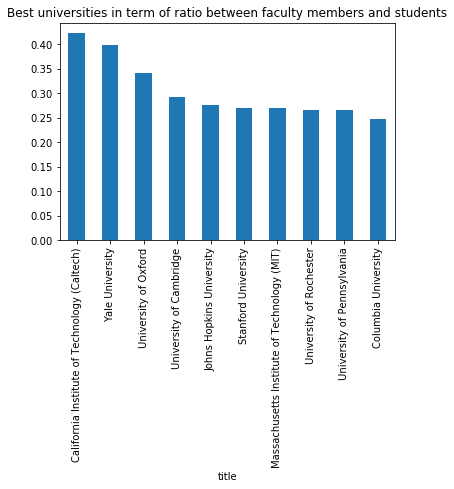

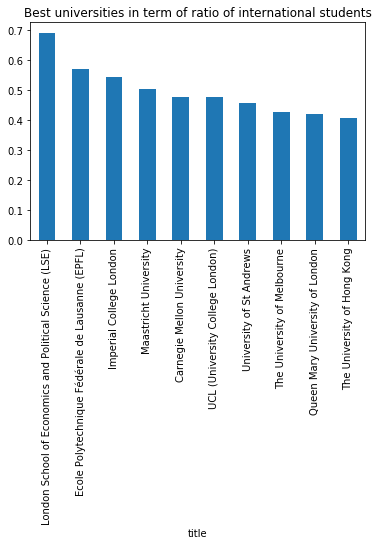

In [124]:
plot_top_by_ratio(rankings, 'universities', 'title')

We can observe above that the best universities for the described ratios are the California Institute of Technology and the London School of Economis and Political Science.

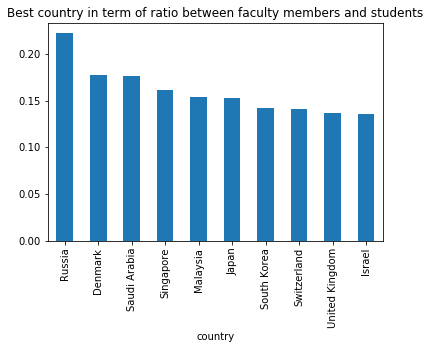

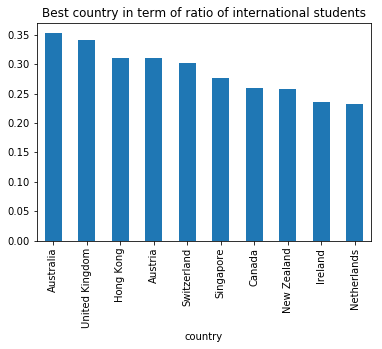

In [125]:
# We group by country and then give to the function that will recalculate ratios and plot
rankings_by_country = rankings.groupby('country').agg(np.sum)
rankings_by_country.reset_index(inplace=True) 

plot_top_by_ratio(rankings_by_country, 'country', 'country')

The best countries for the described ratios are Russia and Australia, as can be seen in the graph above.

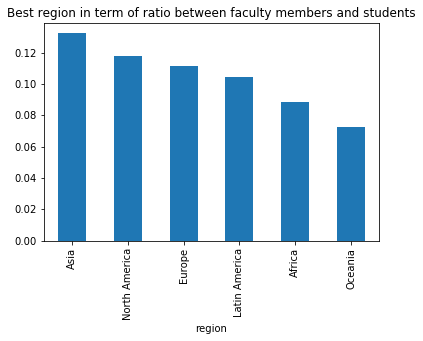

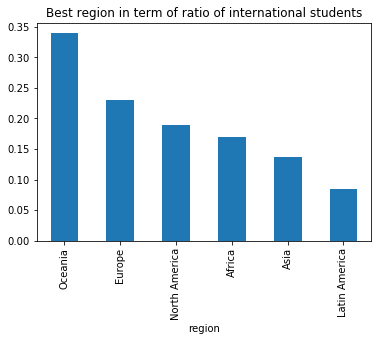

In [126]:
rankings_by_region = rankings.groupby('region').agg(np.sum)
rankings_by_region.reset_index(inplace=True) 

plot_top_by_ratio(rankings_by_region, 'region', 'region')

Concerning the regions, the best are Asia and Oceania respectively for the two demanded ratios. The difference of international students ratio between regions is quite large, and the results can be quite surprising: Oceania comes before Europe, and Africa before Asia, for example.

# Part 2

Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

In [127]:
times_ranking_url = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'


In [128]:
# We repeat the same process for the Times ranking
times_r = requests.get(times_ranking_url)

if(times_r.status_code != requests.codes.ok):
    sys.exit('Could not contact webpage {0}'.format(times_ranking_url))
    
times_rank_data = times_r.json()["data"][:n_top]

times_rankings_dico = []
for uni in times_rank_data:
    values = dict()
    values['title'] = uni['name']
    values['country'] = uni['location']
    values['rank_display'] = uni['rank'].strip("=")
    values['region'] = country_to_region_map.get(values['country'], "Unknown")
    
    values['total student'] = extract_int(uni['stats_number_students'])
    
    values['total inter'] = int(values['total student'] * extract_int(uni['stats_pc_intl_students']) / 100)
    values['total faculty'] = values['total student'] * (1.0 / float(uni['stats_student_staff_ratio']))
    #we don't need the number of international in the faculty, and can't calculate it anyway
    
    times_rankings_dico.append(values)

times_rankings = pd.DataFrame(times_rankings_dico)
times_rankings.head()

,country,rank_display,region,title,total faculty,total inter,total student
0,United Kingdom,1,Europe,University of Oxford,1822.232143,7755,20409
1,United Kingdom,2,Europe,University of Cambridge,1687.064220,6436,18389
2,United States,3,North America,California Institute of Technology,339.846154,596,2209
3,United States,3,North America,Stanford University,2112.666667,3485,15845
4,United States,5,North America,Massachusetts Institute of Technology,1284.712644,3800,11177


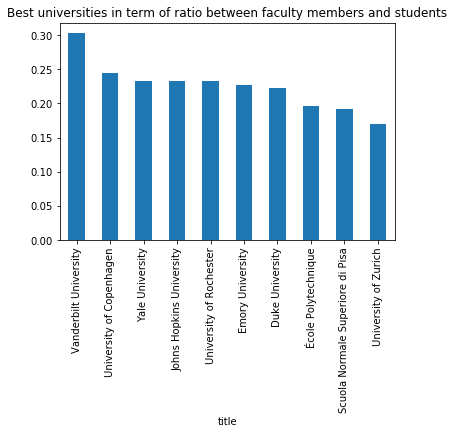

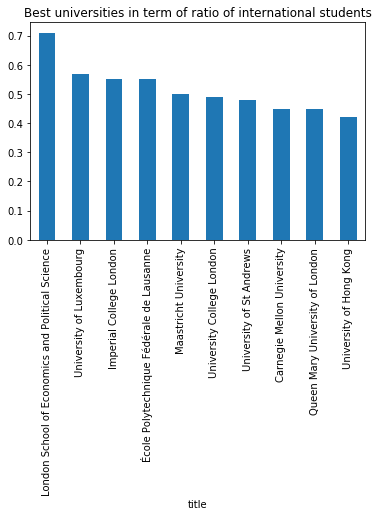

In [129]:
plot_top_by_ratio(times_rankings, 'universities', 'title')

The best unis are the Vanderbilt University and the London School of Economis and Political Science. Caltech isn't even in the first top 10, while it was first in the other ranking.

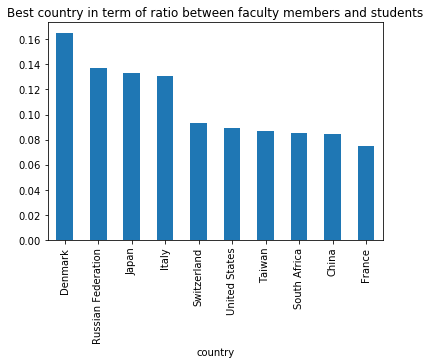

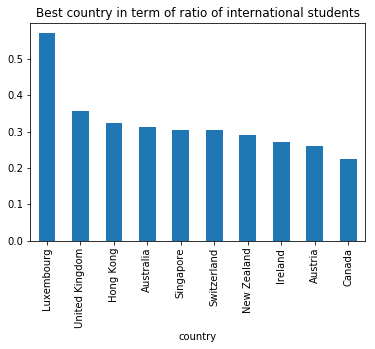

In [130]:
# We group by country and then give to the function that will recalculate ratios and plot
times_rankings_by_country = times_rankings.groupby('country').agg(np.sum)
times_rankings_by_country.reset_index(inplace=True) 

plot_top_by_ratio(times_rankings_by_country, 'country', 'country')

The best countries are Denmark and Luxembourg respectively. We see that Luxembourg is by far the first in terms of international students, which can be explained by the small number of total students in the university.

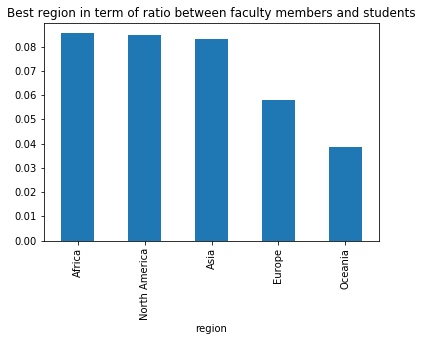

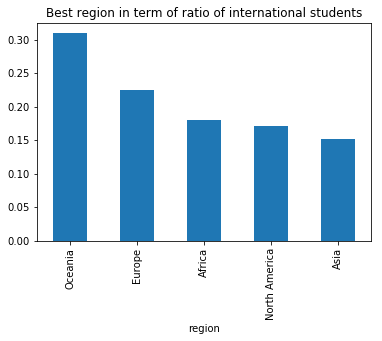

In [131]:
times_rankings_by_region = times_rankings.groupby('region').agg(np.sum)
times_rankings_by_region.reset_index(inplace=True) 

plot_top_by_ratio(times_rankings_by_region, 'region', 'region')

The best regions are Africa and Oceania.

# Part 3
Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.


We describe our best method below. We also tried merging using a distance function on the uni names, but the results were less concluant. Please see the end of the notebook for the first method we tried (using distance function).

In [132]:
# We first merge by exact corresponding uni titles, then look at the remaining ones that haven't been merged.
merged_ranking = pd.merge(rankings, times_rankings, how='outer', on='title', indicator=True, suffixes=('_topU', '_times'))

#Reorder the columns lexicographically so that corresponding columns are side-by-side for easier comparison
merged_ranking.sort_index(axis=1, inplace=True)

#print('Number of merged universities: ' + str(len(merged_ranking)) + ' / ' + str(len(rankings)))
topU_only = merged_ranking[merged_ranking['_merge'] == 'left_only']
times_only = merged_ranking[merged_ranking['_merge'] == 'right_only']
both = merged_ranking[merged_ranking['_merge'] == 'both']

In [133]:
# These are the unis from Times that didn't find a perfect match
times_only.head()

# We can do the same for Top Universities with 'topU_only.head()'

,_merge,country_times,country_topU,inter faculty,rank_display_times,rank_display_topU,ratio_a_times,ratio_a_topU,ratio_b_times,ratio_b_topU,region_times,region_topU,title,total faculty_times,total faculty_topU,total inter_times,total inter_topU,total student_times,total student_topU
200,right_only,United States,NaN,NaN,3,NaN,0.153846,NaN,0.269805,NaN,North America,NaN,California Institute of Technology,339.846154,NaN,596.0,NaN,2209.0,NaN
201,right_only,United States,NaN,NaN,5,NaN,0.114943,NaN,0.339984,NaN,North America,NaN,Massachusetts Institute of Technology,1284.712644,NaN,3800.0,NaN,11177.0,NaN
202,right_only,Switzerland,NaN,NaN,10,NaN,0.068493,NaN,0.379972,NaN,Europe,NaN,ETH Zurich – Swiss Federal Institute of Techno...,1317.328767,NaN,7308.0,NaN,19233.0,NaN
203,right_only,United States,NaN,NaN,15,NaN,0.104167,NaN,0.169989,NaN,North America,NaN,"University of California, Los Angeles",4091.562500,NaN,6677.0,NaN,39279.0,NaN
204,right_only,United Kingdom,NaN,NaN,16,NaN,0.095238,NaN,0.489968,NaN,Europe,NaN,University College London,2886.095238,NaN,14848.0,NaN,30304.0,NaN


We observe that in most cases that were not merged, the uni titles have additional abbreviations, or some characters are a bit different (such as the dash in ETH Zurich). We decide to remove the special characters from the titles, make them all lowercase, and then check if the titles in each dataframe contain each other.

We check if one of the normalized titles is contained in another, and if so, we consider it a match. Note that when there are multiple matches, like with 'The Chinese University of Hong Kong (CUHK)' and 'University of Hong Kong', we ignore the match, but this happens only once for all unis. We could additionally compute a difference function between the conflicting matches to resolve the issue.


In [134]:
#Add a column 'n_title' with a lowercase-only title that was stripped of its special characters and spaces
def add_normalize_title(df):
    n_titles = df['title']
    n_titles = n_titles.str.replace('[^a-zA-Z]', '')
    n_titles = n_titles.str.lower()

    df['n_title'] = n_titles

In [135]:
add_normalize_title(topU_only)
add_normalize_title(times_only)

D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [136]:
# This is what the new column looks like
topU_only['n_title'].head()

0          massachusettsinstituteoftechnologymit
3         californiainstituteoftechnologycaltech
6                     ucluniversitycollegelondon
9     ethzurichswissfederalinstituteoftechnology
10    nanyangtechnologicaluniversitysingaporentu
Name: n_title, dtype: object

In [137]:
# This method compares pairs of uni names, and if one of the unis in a pair is contained in the other, it adds
# a new row to our merged table 'both'.
def find_title_contain(left, right):
    global both
    for (index_topU,uni_name) in left['n_title'].iteritems():
        # create an array of booleans indicating if the uni name is contained in one of the other uni names
        contains = right['n_title'].str.contains(uni_name)

        # we merge and add the row only if there's an unique match.
        if np.sum(contains) == 1:
            #print('Found unique match! :D for ' + uni_name)
            index_times = contains.index[contains == True].tolist()[0]

            topU_part = left.loc[[index_topU]].squeeze().dropna(how='all').drop(['title'])
            times_part = right.loc[[index_times]].squeeze().dropna(how='all')

            # Create a row with both uni details
            joined = topU_part.append(times_part)
            joined.drop(['_merge', 'n_title'], inplace=True)

            # Add thw row to our big table 'both'
            both.loc[-1] = joined
            both.reset_index(drop=True,inplace=True)
            both = both.drop('_merge',  errors='ignore',axis=1)
            
            left = left.drop(index_topU)
            right = right.drop(index_times)

        #elif np.sum(contains) > 1:
            #print('Found multiple matches :O for ' + uni_name)
       # else:
            #print('Found no match :( for ' + uni_name)

In [138]:
find_title_contain(topU_only, times_only)
find_title_contain(times_only, topU_only)

D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We now have a merged dataframe with details of both websites. We were able to merge 147 universities with our method. As described earlier, we also tried another method that can be found at the end of the notebook.

In [139]:
both.head()

,country_times,country_topU,inter faculty,rank_display_times,rank_display_topU,ratio_a_times,ratio_a_topU,ratio_b_times,ratio_b_topU,region_times,region_topU,title,total faculty_times,total faculty_topU,total inter_times,total inter_topU,total student_times,total student_topU
0,United States,United States,2042.0,3,2,0.133333,0.269870,0.219943,0.227422,North America,North America,Stanford University,2112.666667,4285.0,3485.0,3611.0,15845.0,15878.0
1,United States,United States,1311.0,6,3,0.112360,0.193945,0.259963,0.234785,North America,North America,Harvard University,2283.820225,4350.0,5284.0,5266.0,20326.0,22429.0
2,United Kingdom,United Kingdom,2278.0,2,5,0.091743,0.292488,0.349992,0.356899,Europe,Europe,University of Cambridge,1687.064220,5490.0,6436.0,6699.0,18389.0,18770.0
3,United Kingdom,United Kingdom,2964.0,1,6,0.089286,0.342292,0.379979,0.372870,Europe,Europe,University of Oxford,1822.232143,6750.0,7755.0,7353.0,20409.0,19720.0
4,United Kingdom,United Kingdom,2071.0,8,8,0.087719,0.244251,0.549978,0.543567,Europe,Europe,Imperial College London,1390.964912,3930.0,8721.0,8746.0,15857.0,16090.0


# Part 4
Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

In [140]:
c = both.corr()

c[c > 0.5]

,inter faculty,ratio_a_times,ratio_a_topU,ratio_b_times,ratio_b_topU,total faculty_times,total faculty_topU,total inter_times,total inter_topU,total student_times,total student_topU
inter faculty,1.000000,NaN,NaN,NaN,NaN,NaN,0.657178,0.523798,0.582364,NaN,NaN
ratio_a_times,NaN,1.00000,0.70174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratio_a_topU,NaN,0.70174,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratio_b_times,NaN,NaN,NaN,1.000000,0.954239,NaN,NaN,0.512505,NaN,NaN,NaN
ratio_b_topU,NaN,NaN,NaN,0.954239,1.000000,NaN,NaN,0.534772,0.520189,NaN,NaN
total faculty_times,NaN,NaN,NaN,NaN,NaN,1.000000,0.702133,NaN,NaN,0.565559,NaN
total faculty_topU,0.657178,NaN,NaN,NaN,NaN,0.702133,1.000000,NaN,NaN,0.587118,0.609727
total inter_times,0.523798,NaN,NaN,0.512505,0.534772,NaN,NaN,1.000000,0.890727,0.562585,0.539496
total inter_topU,0.582364,NaN,NaN,NaN,0.520189,NaN,NaN,0.890727,1.000000,0.566048,0.638468
total student_times,NaN,NaN,NaN,NaN,NaN,0.565559,0.587118,0.562585,0.566048,1.000000,0.947985


# Part 5
Can you find the best university taking in consideration both rankings? Explain your approach.

In [141]:
both['tot_rank'] = pd.to_numeric(both['rank_display_times']) + pd.to_numeric(both['rank_display_topU'])
both.sort_values(by='tot_rank')['title'][0]

'Stanford University'

## Annexe
#### Get a map table for the name.¶
We saw on part 3 that we thought of a distant method. Here is the code of the distance methode we usend. The sequenceMatcher library we used check which character are used and at which positon and compute a score between two given string. What we do to use this map is the following:

We first use a sequenceMatcher on every possible pair of name from both database. It look on the String and compute a ratio regarding the different character on them and their position. What we imediatly saw were:

- Nearly all element having a score >90% are a perfecte match
- Nearly half of the element having a score >80% and <90% are a match. Most of the false positive are some small name with just a word changing, and this word have similare letter than the other
- Nearly all element having <80% aren't a match

As only the small name pass the 80%, we decided to compare the word of each string on each other and compute two new scores, one for each side of verification. Those having a small name have directly a poor score and those having juste one more word or the initial still have a good score. We just had to take all the pair that have more than 80% on the 3 scores to have a very good map table.


In [142]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


def similitude(tableOne, tableTwo):
    #Get a new table containing only the name of university from both dataframe
    name = pd.DataFrame()
    name['name1'] = tableOne['title']
    name['name2'] = tableTwo['title']
    name = name.reset_index().drop('index',1).drop(name.index[199])
    #name = name.drop(name.index[199])

    #Compute a ratio of similarity between all possible pair of name, find the best and pair them with the ratio
    matchName = []
    for n in name['name1']:
        maxRatio = -100
        bestMatch = ''
        for m in name['name2']:
            if similar(n,m) > maxRatio:            
                maxRatio = similar(n,m)
                bestMatch = m
        matchName.append({'ratio':maxRatio, 'name1':n, 'name2':bestMatch})
    newName = pd.DataFrame.from_dict(matchName)

    #Compute two ratio on each pair of name, regarding if each word of a pair is in the other pair's string
    secondRatio = []
    thirdRatio = []
    for index, row in newName.iterrows():
        nameOne = re.sub('[,();-]', '', row['name1']).split(' ')
        nameTwo = re.sub('[,();-]', '', row['name2']).split(' ')
        counter1 = 0
        match1 = 0
        for elem in nameOne:
            counter1 += 1
            if elem in nameTwo:
                match1 += 1
        if match1 > 0 :
            rat1 = match1/counter1
        else:
            rat1 = 0
            
        counter2 = 0
        match2 = 0
        for elem in nameTwo:
            counter2 += 1
            if elem in nameOne:
                match2 += 1
        if match2 > 0 :
            rat2 = match2/counter2
        else:
            rat2 = 0    
        secondRatio.append(rat1)
        thirdRatio.append(rat2)
    newName['ratio2'] = secondRatio
    newName['ratio3'] = thirdRatio

    #Only hold the pair which have all ratio above 80%
    newNamehighratio = newName.query('ratio >= 0.80 and ratio2 >= 0.80 and ratio3 >= 0.80')
    return newNamehighratio

similitude(times_rankings, rankings).head()

,name1,name2,ratio,ratio2,ratio3
0,University of Oxford,University of Oxford,1.000000,1.0,1.0
1,University of Cambridge,University of Cambridge,1.000000,1.0,1.0
2,California Institute of Technology,California Institute of Technology (Caltech),0.871795,1.0,0.8
3,Stanford University,Stanford University,1.000000,1.0,1.0
4,Massachusetts Institute of Technology,Massachusetts Institute of Technology (MIT),0.925000,1.0,0.8
